In [39]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [40]:
!pip install matplotlib

In [41]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [42]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [43]:
directory = r"C:\Users\aayus\ML learning\Projects\Potato Plant Disease\PlantVillage"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=directory,
    seed = 123,
    shuffle=True,
    image_size=[IMAGE_SIZE, IMAGE_SIZE],
    batch_size=BATCH_SIZE
)

Found 901 files belonging to 3 classes.


In [44]:
len(dataset)

29

In [45]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [46]:
class_names = dataset.class_names

In [47]:
import numpy as np
for batch_size, label_size in dataset.take(1):
    print("image_shape :", batch_size)
    print("label :", label_size.numpy)
    print("image :", batch_size[0])

image_shape : tf.Tensor(
[[[[146.89827  134.89827  138.89827 ]
   [117.32479  105.32479  109.32479 ]
   [159.80559  147.80559  151.80559 ]
   ...
   [189.00586  179.00586  178.00586 ]
   [188.99608  178.99608  177.99608 ]
   [188.99413  178.99413  177.99413 ]]

  [[125.09177  113.09177  117.09177 ]
   [153.73062  141.73062  145.73062 ]
   [135.74919  123.74919  127.74919 ]
   ...
   [187.0177   177.0177   176.0177  ]
   [187.01765  177.01765  176.01765 ]
   [186.02547  176.02547  175.02547 ]]

  [[131.32344  119.323456 123.323456]
   [126.39447  114.39447  118.39447 ]
   [143.41678  131.41678  135.41678 ]
   ...
   [190.0195   180.0195   179.0195  ]
   [190.00006  180.00006  179.00006 ]
   [190.       180.       179.      ]]

  ...

  [[133.22902  120.22902  127.22902 ]
   [135.18733  122.18733  129.18733 ]
   [146.90227  133.90227  140.90227 ]
   ...
   [166.02007  156.02007  165.02007 ]
   [160.97076  150.97076  159.97076 ]
   [167.92755  157.92755  166.92755 ]]

  [[138.96088  125.9

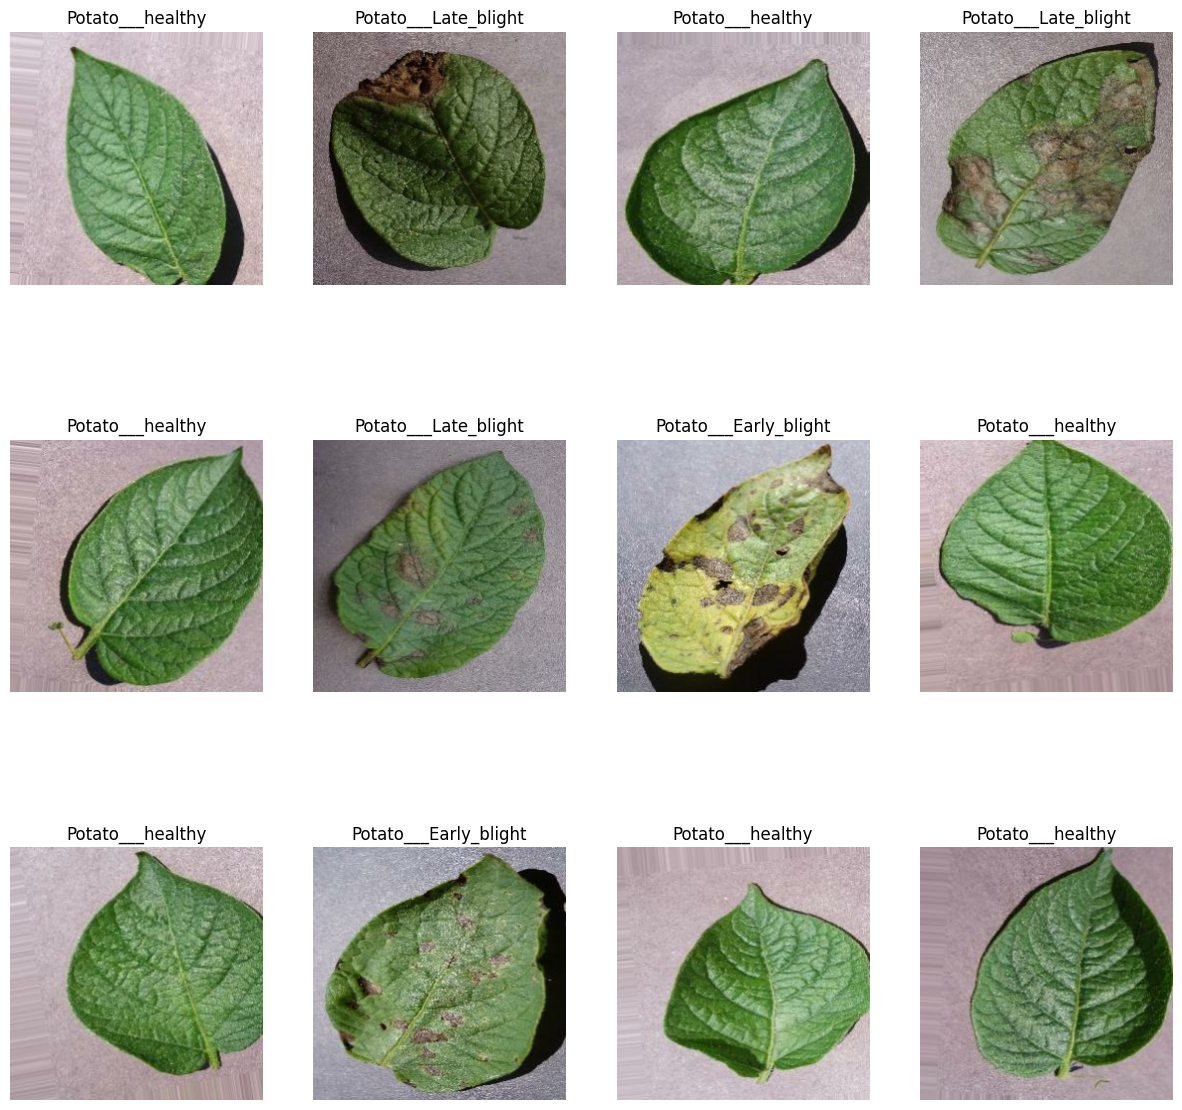

In [48]:
plt.figure(figsize=(15,15))
for img, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [49]:
len(dataset)

29

In [50]:
train_size = 0.8
len(dataset) * train_size

23.200000000000003

In [51]:
train_ds = dataset.take(23)

In [52]:
test_ds = dataset.skip(23)

In [53]:
len(test_ds)

6

In [54]:
val_size = 0.1
len(dataset) * val_size

2.9000000000000004

In [55]:
val_ds = test_ds.take(2)

In [56]:
len(val_ds)

2

In [57]:
test_ds = test_ds.skip(2)

In [58]:
len(test_ds)

4

In [59]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [60]:
len(train_ds), len(val_ds), len(test_ds)

(23, 2, 4)

In [61]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [63]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [64]:
train_ds


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [87]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

resize_and_rescale = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255)
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)

In [88]:
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255)
])

In [90]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [91]:
 model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)           │ (32, 255, 255, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (32, 253, 253, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (32, 126, 126, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (32, 124, 124, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [93]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 826ms/step - accuracy: 0.3299 - loss: 1.1097 - val_accuracy: 0.2969 - val_loss: 1.0932
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 797ms/step - accuracy: 0.4385 - loss: 1.0763 - val_accuracy: 0.7188 - val_loss: 1.0115
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 918ms/step - accuracy: 0.5323 - loss: 0.9595 - val_accuracy: 0.7031 - val_loss: 0.6191
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 936ms/step - accuracy: 0.6789 - loss: 0.6637 - val_accuracy: 0.7969 - val_loss: 0.5509
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 862ms/step - accuracy: 0.7462 - loss: 0.5481 - val_accuracy: 0.7344 - val_loss: 0.5314
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 831ms/step - accuracy: 0.7440 - loss: 0.5681 - val_accuracy: 0.8594 - val_loss: 0.3228
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 834ms/step - accuracy: 0.7961 - loss: 0.4481 - val_accuracy: 0.8594 - val_loss: 0.2859
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 819ms/step - accuracy: 0.8446 - loss: 0.3592 - val_accu

In [96]:
# model.save('model.keras')

In [100]:
model = tf.keras.models.load_model('model.h5')

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
predicted label: Potato___Late_blight


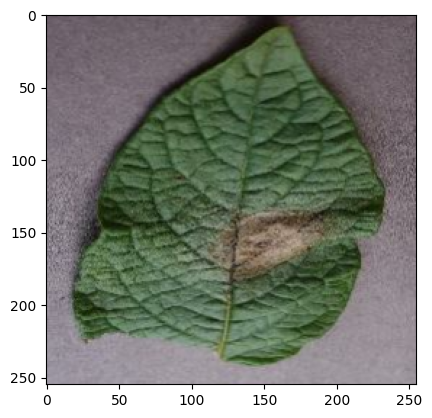

In [107]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [108]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


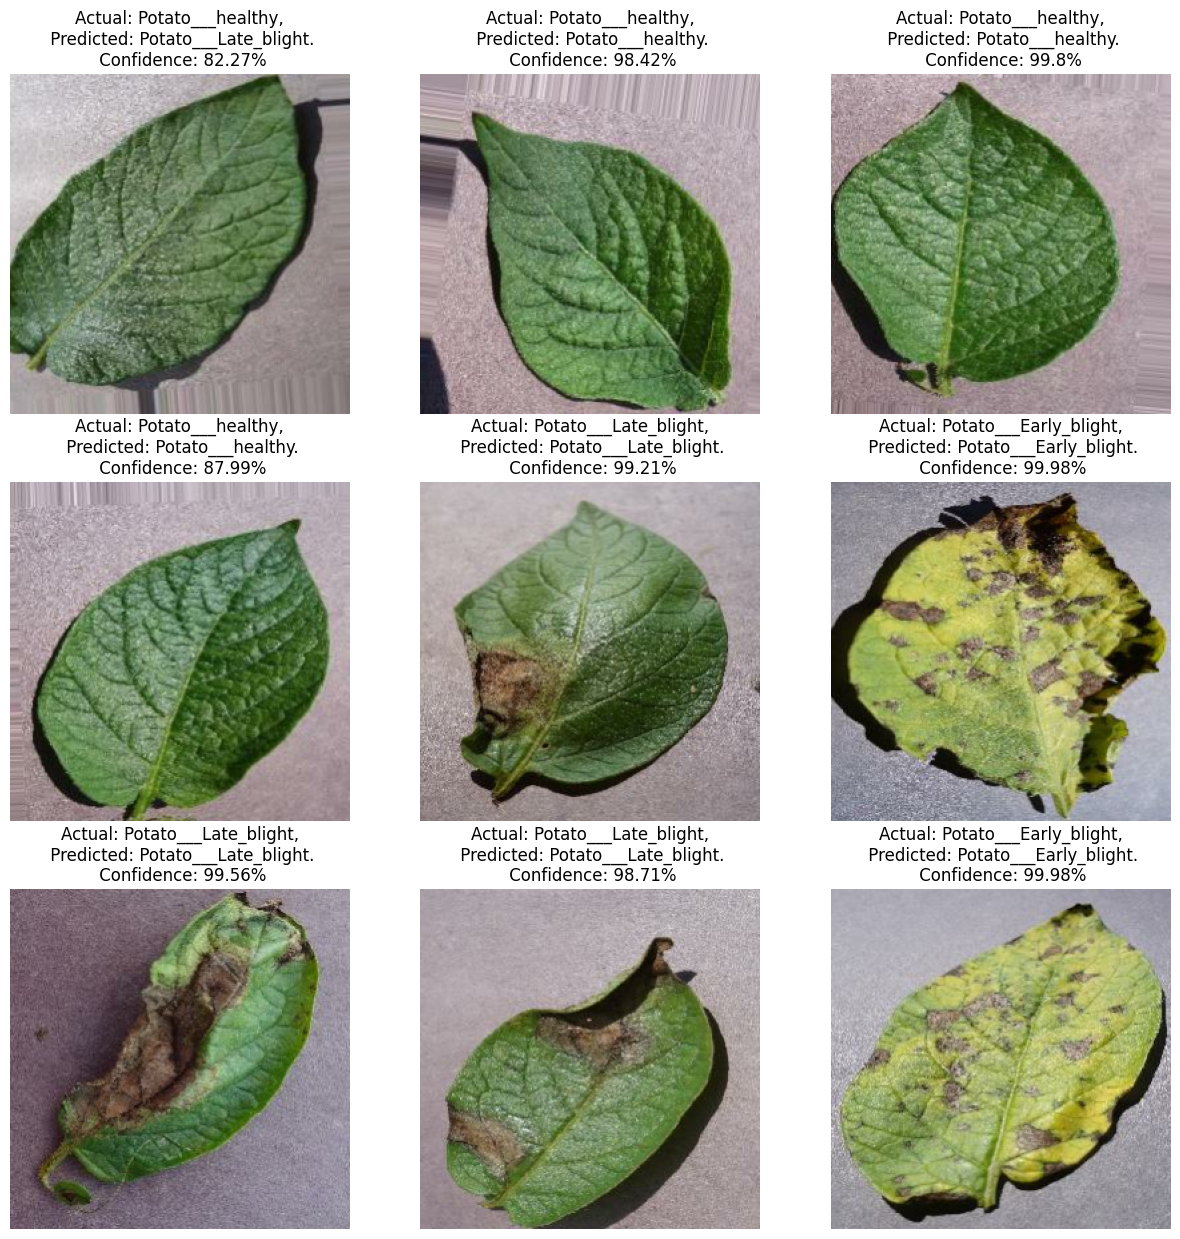

In [109]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [110]:
    print(tf.__version__)


2.19.0
